<a href="https://colab.research.google.com/github/CarlosSMWolff/Quantum-Optics-Course/blob/main/5_Spectrum-JC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical steady state solutions of a driven, open JC model

In this notebook we will create our custom functions with numpy to simulate an open quantum system

Load necessary packages

In [1]:
# Load numpy for matrix operations
import numpy as np
# Load matplotlib to create plots
import matplotlib.pyplot as plt
from numpy import kron, sqrt, log10, exp, cosh, sinh, pi

import scipy


from tqdm import tqdm

First we build the quantum operators that we use to describe the states and dynamics of the system.

In this example, we have a cavity (annihilation operator $a$) and a two-level system (lowering operator $\sigma$).

We will use the notation "red" for operators that act on the respective spaces of the cavity or the TLS alone, not in the global space that is a tensor product of both.

## Operators

In [2]:
# Define the annihilation operator for a single HO
ncav = 5 # Truncation number: i.e. number of levels of the HO included.
ared = np.diag(np.sqrt(np.arange(1,ncav)),k=1)

# Define the annihilation operator for a TLS
sigmared = np.array([[0,1],[0,0]])



Remember that we work in a Hilbert space which is a tensor product of the cavity Hilbert space and the TLS Hilbert space. Therefore, to build the operators we need to also build tensor products of the reduced operators defined above, for instance:

$$a_\text{total} = a_\text{cavity}\otimes I_{\text{TLS}} $$ 
$$\sigma_\text{total} = I_\text{cavity}\otimes \sigma_{\text{TLS}} $$

This tensor product is performed with numpy's Kronecker product ``np.kron``. The identity is created with ``np.eye``.



In [3]:
a = np.kron(ared,np.eye(2))
sigma = np.kron(np.eye(ncav),sigmared)

h = len(a)
print(f"The size of our combined Hilbert space is {h}")

The size of our combined Hilbert space is 10


# Spectrum of emission: JC with incoherent pumping

---



In [17]:
g = 10.
kappa = 0.1
gamma = 0.01
P = 0.01
Delta_a = 0
Delta_q = 0

In [18]:
def lindblad(op):
  id = np.eye(len(op))
  return 1/2*(2*kron(op,op)-kron(op.T@op,id)-kron(id,op.T@op))

def gen_liouvillian(H,c_ops):
  h = len(H)
  id = np.eye(h)

  LH = -1j*(kron(H,id) - kron(id,H)) 
  L = LH
  for op in c_ops:
    L = L + lindblad(op)
  return L


def steadystate_np(H,c_ops: list):
  h = len(H)
  id = np.eye(h)
  LH = -1j*(kron(H,id) - kron(id,H)) 
  L = LH


  for op in c_ops:
    L = L + lindblad(op)

  Lnew = L.copy()
  Lnew[0,:] = (np.eye(h)).flatten()
  ind = np.zeros(h**2); ind[0]=1

  rhoss = np.linalg.solve(Lnew,ind)
  rhossM = np.reshape(rhoss,(h,h))
  
  return rhossM

def gen_Hamiltonian(Delta_a,Delta_q, g):
  H = Delta_q*sigma.T@sigma + g*(a.T@sigma + a@sigma.T)
  return H

In [19]:
H = gen_Hamiltonian(Delta_a, Delta_q, g)
c_ops = [sqrt(kappa)*a, sqrt(gamma)*sigma, sqrt(P)*sigma.T]

rhoSS = steadystate_np(H, c_ops)
L = gen_liouvillian(H,c_ops)

Method of the inverse

In [40]:
idL = np.eye(len(L))
rhs = (rhoSS @ a.T).flatten()


# Define sparse version of these matrixes
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

L_sp = csr_matrix(L)
idL_sp = csr_matrix(idL)
rhs_sp = csr_matrix(rhs)


In [41]:
def Spectrum_inverse(L,w,rhs):
  X = spsolve(L_sp + 1j*w*idL_sp, rhs)
  Xm = X.reshape((h,h))
  return -1/pi*np.real(np.trace(a@Xm))

In [42]:
wmin, wmax, nw = -4*g, 4*g, 200
wgrid = np.linspace(wmin,wmax,nw)

In [43]:
spectrum = np.asarray([Spectrum_inverse(L,w,rhs) for w in wgrid])

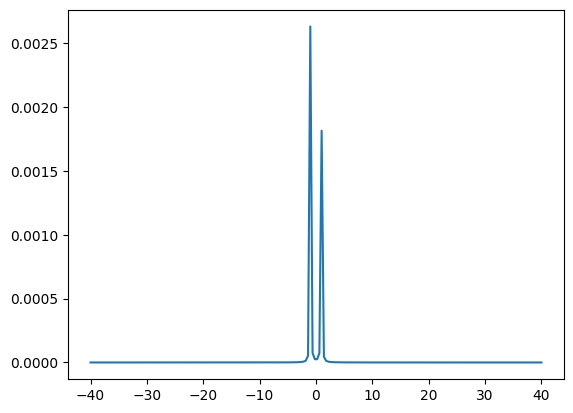

In [45]:
plt.plot(wgrid,spectrum)
plt.show()

Loop in frequency of the drive

In [46]:
Delta_grid = np.linspace(wmin,wmax,100)

In [47]:
spectrum_Delta = []
for Delta_q in tqdm(Delta_grid):
  H = gen_Hamiltonian(Delta_a, Delta_q, g)
  c_ops = [sqrt(kappa)*a, sqrt(gamma)*sigma, sqrt(P)*sigma.T]
  rhoSS = steadystate_np(H, c_ops)
  L = gen_liouvillian(H,c_ops)

  idL = np.eye(len(L))
  rhs = (rhoSS @ a.T).flatten()

  L_sp = csr_matrix(L)
  idL_sp = csr_matrix(idL)
  rhs_sp = csr_matrix(rhs)

  spectrum_Delta.append(np.asarray([Spectrum_inverse(L,w,rhs) for w in wgrid]))

spectrum_Delta = np.asarray(spectrum_Delta)




100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


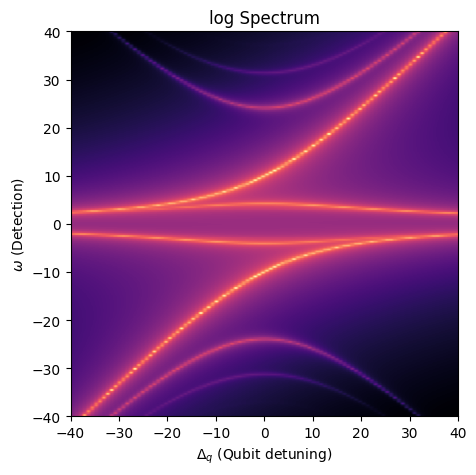

In [51]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(np.log(np.abs(np.flip(spectrum_Delta.T,1))), extent=[wmin,wmax,wmin,wmax], aspect = 'auto', cmap = 'magma')
plt.ylabel("$\omega$ (Detection)")
plt.xlabel("$\Delta_q$ (Qubit detuning)")
plt.title("log Spectrum")

plt.show()

In [52]:
def eigenvals(Delta_q, n,idx):
  if idx==0:
    return Delta_q/2 - 0.5*sqrt(Delta_q**2 + 4*g**2*n)
  if idx==1:
   return Delta_q/2 + 0.5*sqrt(Delta_q**2 + 4*g**2*n)

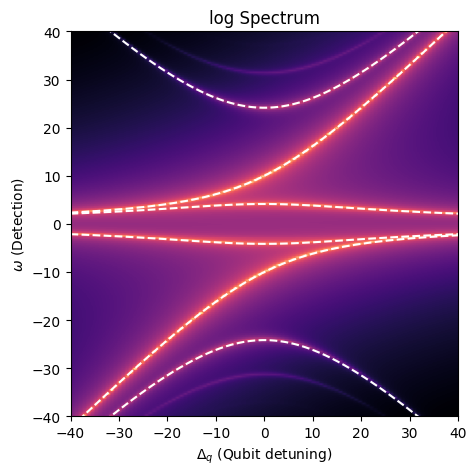

In [53]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(np.log(np.abs(np.flip(spectrum_Delta.T,1))), extent=[wmin,wmax,wmin,wmax], aspect = 'auto', cmap = 'magma')

plt.plot(Delta_grid, eigenvals(Delta_grid, 1, 0), 'w--')
plt.plot(Delta_grid, eigenvals(Delta_grid, 1, 1),'w--')
plt.plot(Delta_grid,  eigenvals(Delta_grid, 2, 1)-eigenvals(Delta_grid, 1, 1),'w--')
plt.plot(Delta_grid,  eigenvals(Delta_grid, 2, 0)-eigenvals(Delta_grid, 1, 1),'w--')
plt.plot(Delta_grid,  eigenvals(Delta_grid, 2, 1)-eigenvals(Delta_grid, 1, 0),'w--')
plt.plot(Delta_grid,  eigenvals(Delta_grid, 2, 0)-eigenvals(Delta_grid, 1, 0),'w--')

plt.ylabel("$\omega$ (Detection)")
plt.ylim(wmin,wmax)
plt.xlabel("$\Delta_q$ (Qubit detuning)")
plt.title("log Spectrum")

plt.show()